# GBDT模型

## GBDT模型主要步骤

GBDT的主要步骤概括如下：

1. **初始化**：
    - 首先，GBDT会用一个简单的模型（如常数模型）对所有样本做出初始预测。
2. **迭代优化**：
    - **计算残差**：基于当前模型的预测结果，计算每个样本的真实标签与预测值之间的梯度（对于回归问题通常是真实值减去预测值；对于分类问题，则使用损失函数的负梯度）。
    - **拟合决策树**：将这些残差作为新的目标变量，训练一个决策树来拟合这些残差。
    - **更新预测**：将新训练的决策树加入到模型中，更新每个样本的预测值为原预测值加上新决策树的输出。
    - **重复上述过程**，直到达到预设的迭代次数或满足停止条件。
3. **构建最终模型**：
    - 所有决策树的加权预测结果组合起来，形成最终的强学习器。

# GBDT模型案例（回归）

## GradientBoostingRegressor

- **n_estimators**：弱学习器（决策树）的数量
    - 增加树的数量可能提高模型性能，但是过多的树可能导致过拟合
- **max_depth**：单棵决策树的最大深度
    - 控制树的复杂度。较小的值可以防止过拟合，较大的值可以提高模型的拟合能力
- **min_samples_split**：控制内部节点分裂所需的最小样本数。
    - 较大的值可以减少模型的过拟合。
- **min_samples_leaf**：叶子节点所需的最小样本数
    - 避免叶子节点包含少量样本，可以减少过拟合
- **max_features**：在每次分裂时考虑的最大特征数
    - 随机选取部分特征可以增加模型的随机性，从而减少过拟合
- **learning_rate**：每棵树对最终预测的贡献权重（步长）
    - 控制更新步长，较小的值可以提高模型的泛化性能，但需要更多的树（更大的 n_estimators）
- **subsample**：用于拟合每棵树的样本比例（子采样）
    - 默认值：1.0（使用所有样本）。作用：通过随机采样数据集的一部分训练每棵树，降低过拟合风险
- **random_state**：设置随机种子，用于结果的可复现性
- **verbose**：控制是否打印训练过程中的输出信息
    - 0：不输出
    - 1：每完成一棵树的训练输出信息
    - 2：每完成一次并行操作输出信息

## 波士顿房价数据集

**Boston Housing Dataset（波士顿房价数据集）**是一个回归数据集，该数据集包含506个样本，每个样本有13个特征，该数据集用于根据犯罪率、房屋房间数、空气污染等因素对波士顿地区的房价进行预测。

- MEDV：住房价格中位数（单位：千美元）
- CRIM：该镇的人均犯罪率
- ZN：住宅用地超过 25000 平方英尺的比例（%）
- INDUS：非零售商用土地比例（%）
- CHAS：是否靠近查尔斯河（1=是，0=否）
- NOX：一氧化氮浓度（空气污染指标，单位：ppm）
- RM：每栋住宅的平均房间数
- AGE：1940 年之前建成房屋的比例（%）
- DIS：到波士顿五个中心区域的加权距离
- RAD：距离高速公路的便利指数
- TAX：每 $10,000 资产的房产税率
- PTRATIO：城镇师生比例
- B：黑人比例指标
- LSTAT：低收入人群比例（%）

In [6]:
# 导入必要的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, export_text, plot_tree
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# 加载波士顿房价数据集
# 该数据集包含506个样本，每个样本有13个特征，用于预测房价
boston = fetch_openml(name="boston", version=1, as_frame=True)
X = boston.data  # 特征变量
y = boston.target  # 目标变量（房价）
boston

{'data':         CRIM    ZN  INDUS CHAS    NOX     RM   AGE     DIS RAD    TAX  \
 0    0.00632  18.0   2.31    0  0.538  6.575  65.2  4.0900   1  296.0   
 1    0.02731   0.0   7.07    0  0.469  6.421  78.9  4.9671   2  242.0   
 2    0.02729   0.0   7.07    0  0.469  7.185  61.1  4.9671   2  242.0   
 3    0.03237   0.0   2.18    0  0.458  6.998  45.8  6.0622   3  222.0   
 4    0.06905   0.0   2.18    0  0.458  7.147  54.2  6.0622   3  222.0   
 ..       ...   ...    ...  ...    ...    ...   ...     ...  ..    ...   
 501  0.06263   0.0  11.93    0  0.573  6.593  69.1  2.4786   1  273.0   
 502  0.04527   0.0  11.93    0  0.573  6.120  76.7  2.2875   1  273.0   
 503  0.06076   0.0  11.93    0  0.573  6.976  91.0  2.1675   1  273.0   
 504  0.10959   0.0  11.93    0  0.573  6.794  89.3  2.3889   1  273.0   
 505  0.04741   0.0  11.93    0  0.573  6.030  80.8  2.5050   1  273.0   
 
      PTRATIO       B  LSTAT  
 0       15.3  396.90   4.98  
 1       17.8  396.90   9.14  
 2       

## 代码实现

=== 评估指标 (Gradient Boosting) ===
MSE: 6.2089
RMSE: 2.4918
MAE: 1.9122
MAPE: 10.06%
R² Score: 0.9153


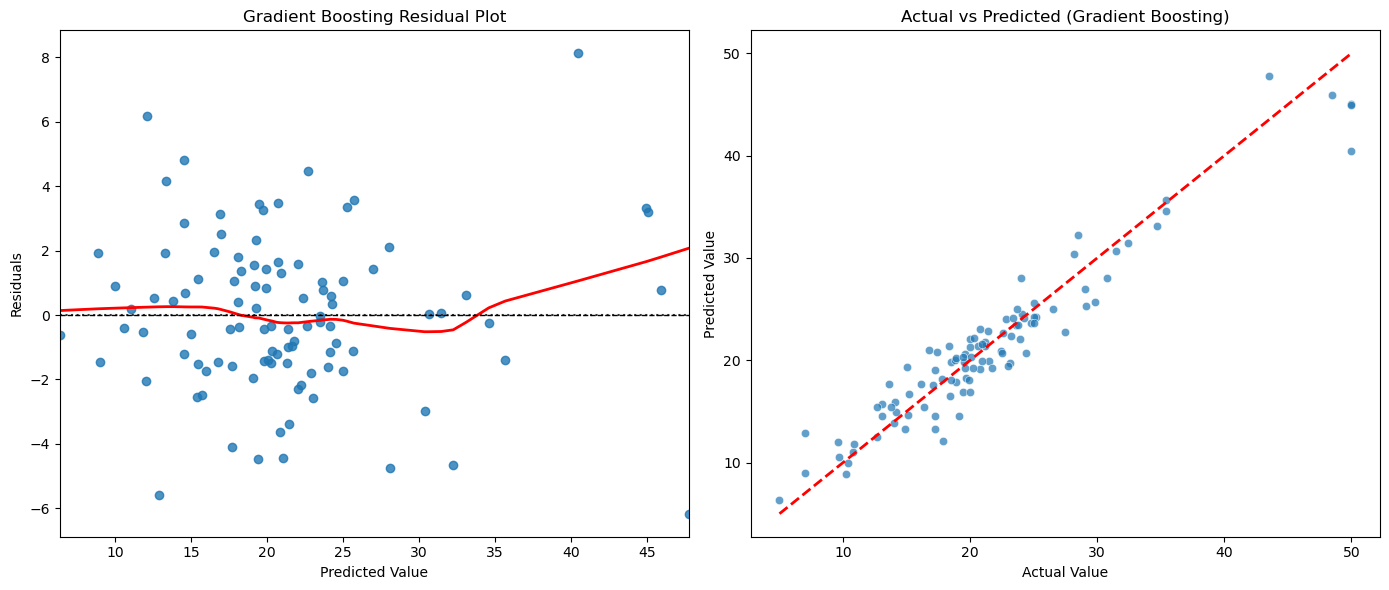

In [7]:
# 划分训练集和验证集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 定义 Gradient Boosting 回归模型
gb_regressor = GradientBoostingRegressor(
    random_state=42
)

# 训练模型
gb_regressor.fit(X_train, y_train)

# 进行预测
y_pred = gb_regressor.predict(X_test)

# 计算评估指标
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2 = r2_score(y_test, y_pred)

# 输出评估指标
print("=== 评估指标 (Gradient Boosting) ===")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R² Score: {r2:.4f}")

# 计算残差
residuals = y_test - y_pred

# 可视化部分
plt.figure(figsize=(14, 6))

# 1. 残差图
plt.subplot(1, 2, 1)
sns.residplot(x=y_pred, y=residuals, lowess=True, line_kws={'color': 'red', 'lw': 2})
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.xlabel("Predicted Value")
plt.ylabel("Residuals")
plt.title("Gradient Boosting Residual Plot")

# 2. 实际值 vs 预测值
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 
         color='red', linestyle='--', linewidth=2)
plt.xlabel("Actual Value")
plt.ylabel("Predicted Value")
plt.title("Actual vs Predicted (Gradient Boosting)")

plt.tight_layout()
plt.show()

# GBDT模型可视化

## export_text

**export_text**: 将训练好的决策树模型转换为可读的文本规则
- `decision_tree`: 训练好的决策树模型
- `feature_names`: 特征名称列表
- `class_names`: 类别名称列表
- `max_depth`: 导出的最大深度
- `spacing`: 缩进空格数
- `decimals`: 数值的小数位数
- `show_weights`: 是否显示样本权重信息

In [3]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# GBDT可视化
# 文本形式展示决策规则
tree_rules = export_text(
    gb_regressor.estimators_[0, 0],  # 第0阶段的第0棵树
    feature_names=list(X.columns)
)

print("\n决策规则:")
print(tree_rules)


决策规则:
|--- RM <= 6.94
|   |--- LSTAT <= 14.40
|   |   |--- DIS <= 1.38
|   |   |   |--- value: [21.68]
|   |   |--- DIS >  1.38
|   |   |   |--- value: [0.10]
|   |--- LSTAT >  14.40
|   |   |--- CRIM <= 6.93
|   |   |   |--- value: [-5.73]
|   |   |--- CRIM >  6.93
|   |   |   |--- value: [-10.89]
|--- RM >  6.94
|   |--- RM <= 7.44
|   |   |--- NOX <= 0.66
|   |   |   |--- value: [10.50]
|   |   |--- NOX >  0.66
|   |   |   |--- value: [-8.70]
|   |--- RM >  7.44
|   |   |--- CRIM <= 2.74
|   |   |   |--- value: [22.76]
|   |   |--- CRIM >  2.74
|   |   |   |--- value: [-0.90]



## plot_tree

**plot_tree**: 生成直观的决策树树形结构图
- `decision_tree`: 训练好的决策树模型
- `max_depth`: 显示的最大深度
- `feature_names`: 特征名称列表
- `class_names`: 类别名称列表
- `label`: 节点信息显示内容
- `filled`: 是否填充颜色
- `impurity`: 是否显示不纯度
- `node_ids`: 是否显示节点ID
- `proportion`: 是否显示比例
- `rounded`: 是否圆角边框
- `precision`: 数值显示精度
- `fontsize`: 字体大小

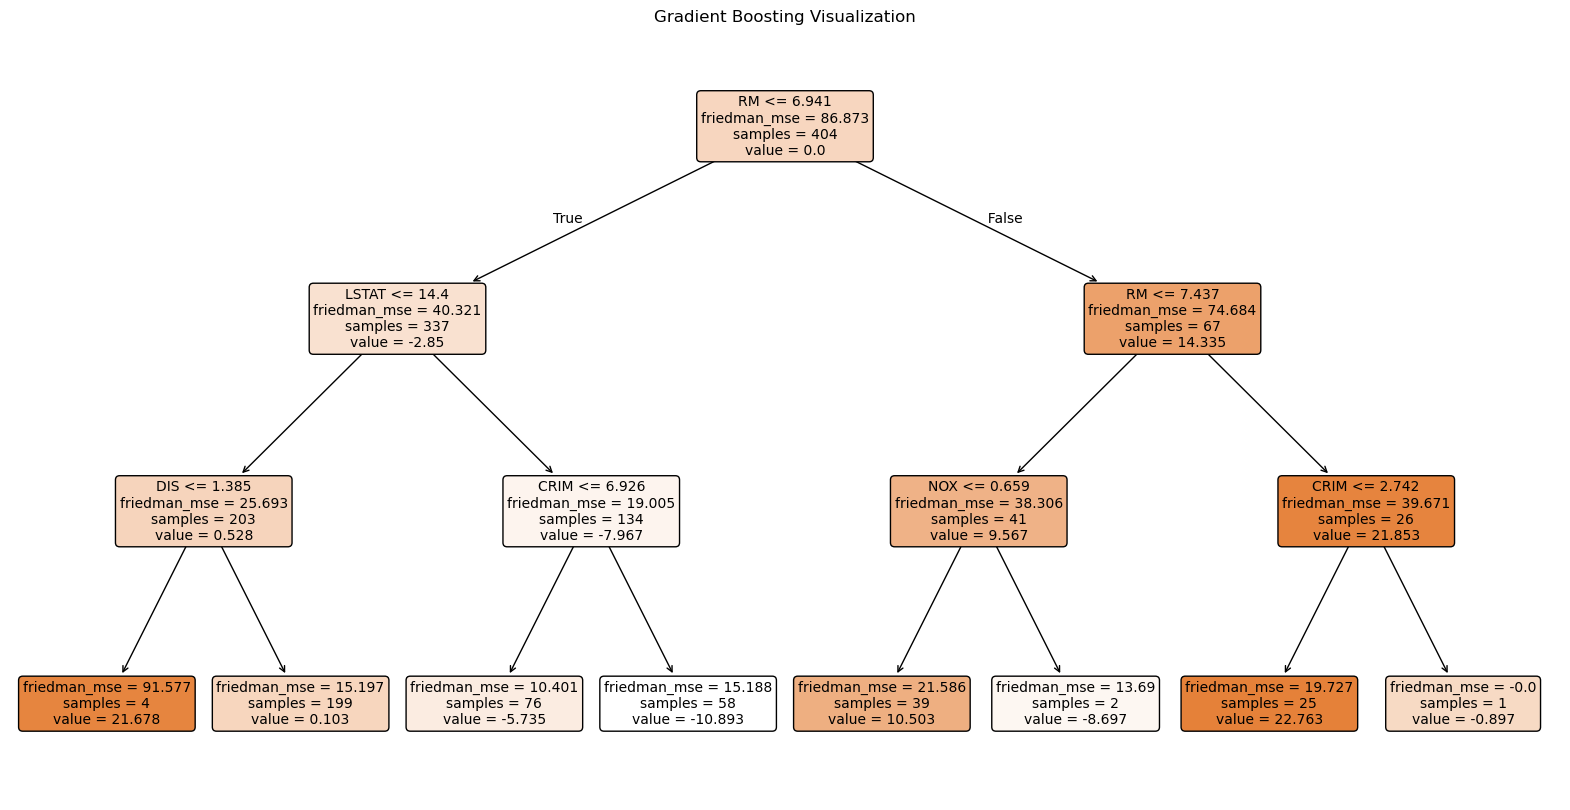

In [4]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# 可视化 Gradient Boosting 中的第一棵树
plt.figure(figsize=(20, 10))
plot_tree(
    gb_regressor.estimators_[0, 0],              # 获取第一棵树（注意是二维数组：estimators_[stage, class]）
    feature_names=X.columns,
    class_names=["Not Survived", "Survived"],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Gradient Boosting Visualization")
plt.show()

# 特征重要度

**特征重要性(feature importance)**是GBDT模型中用于衡量各个特征对预测结果贡献程度的指标。
- 对于GBDT中的每棵树，每次决策树在某特征上进行划分时，都会带来一定的分裂误差下降（例如 MSE 下降）。 
- 把所有由该特征引起的MSE下降值累加，再进行归一化（总和为 1），即可得到特征重要度。
- 计算公式为：
$$\text{Importance}_j = \frac{1}{N_{\text{trees}}} \sum_{T} \sum_{t \in T} \frac{\text{ΔMSE}_t}{\text{TotalSplits}_T} \cdot I(j \in t)$$
- 其中：
    - $\text{ΔMSE}_t$：节点$t$的MSE下降 
    - $I(j \in t)$：指示函数（特征$j$是否用于分裂）
    - $N$：GBDT模型中树的棵树 

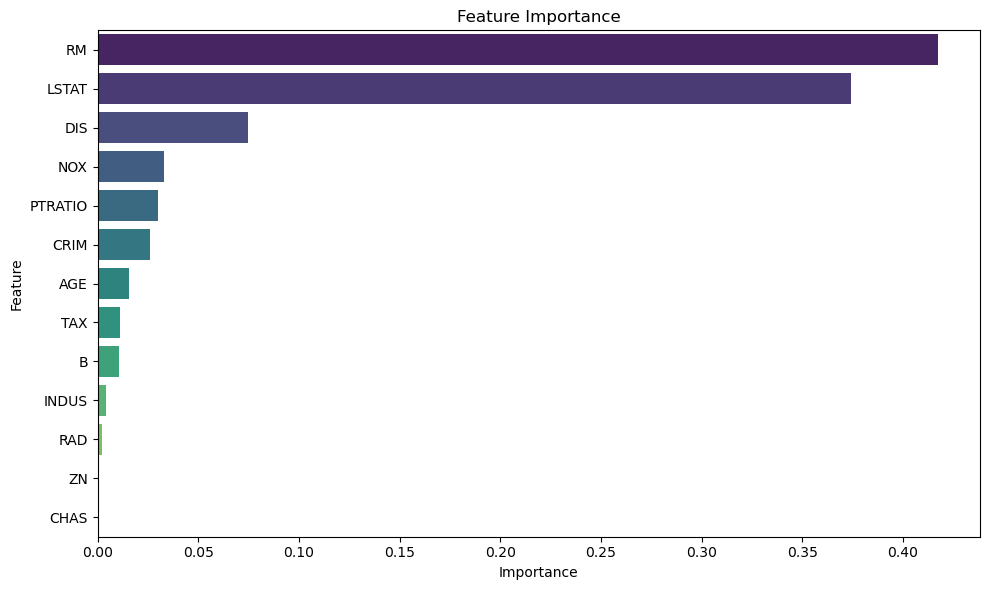

In [5]:
# 特征重要性
feature_imp = pd.DataFrame({
    'Feature': X.columns,
    'Importance': gb_regressor.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_imp, palette='viridis')
plt.title("Feature Importance")
plt.tight_layout()
plt.show()